## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images. Next, calculate distortion coefficients and test undistortion on test images

In [1]:
import numpy as np
import math
import cv2
import glob
import os
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from line import Line
from threshold import combine_threshold, color_threshold
from process_video import load_calib, undistort, warp_perspective, draw_lane_lines
%matplotlib inline

calibration mtx and dist loaded. img_size=(1280, 720)


In [2]:
mtx, dist, img_size = load_calib('calib.p') 

calibration mtx and dist loaded. img_size=(1280, 720)


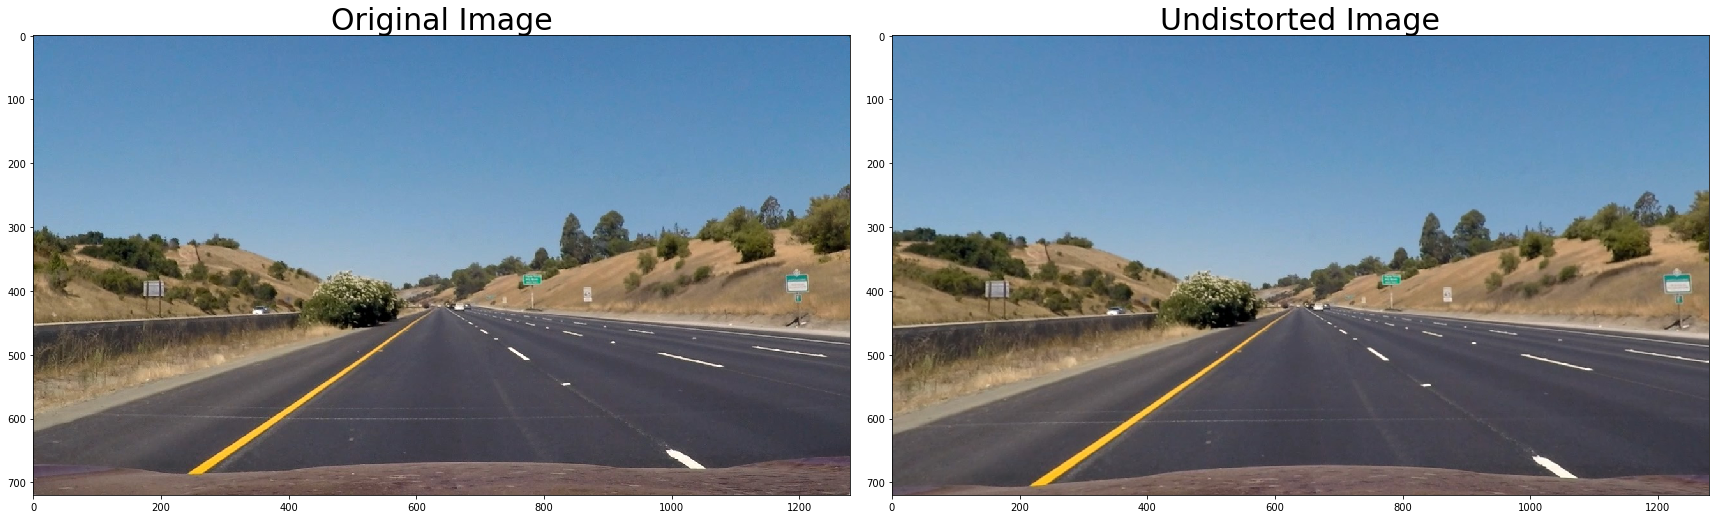

In [3]:
test_image = '../test_images/straight_lines1.jpg'

#img = cv2.imread(test_image)
img = mpimg.imread(test_image)

undistorted = undistort(img)
outfile = test_image.replace('test_images', 'output_images').replace('.jpg', '_undistorted.jpg')
mpimg.imsave(outfile, undistorted)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=30)

## Use color transforms, gradients, etc., to create a thresholded binary image.

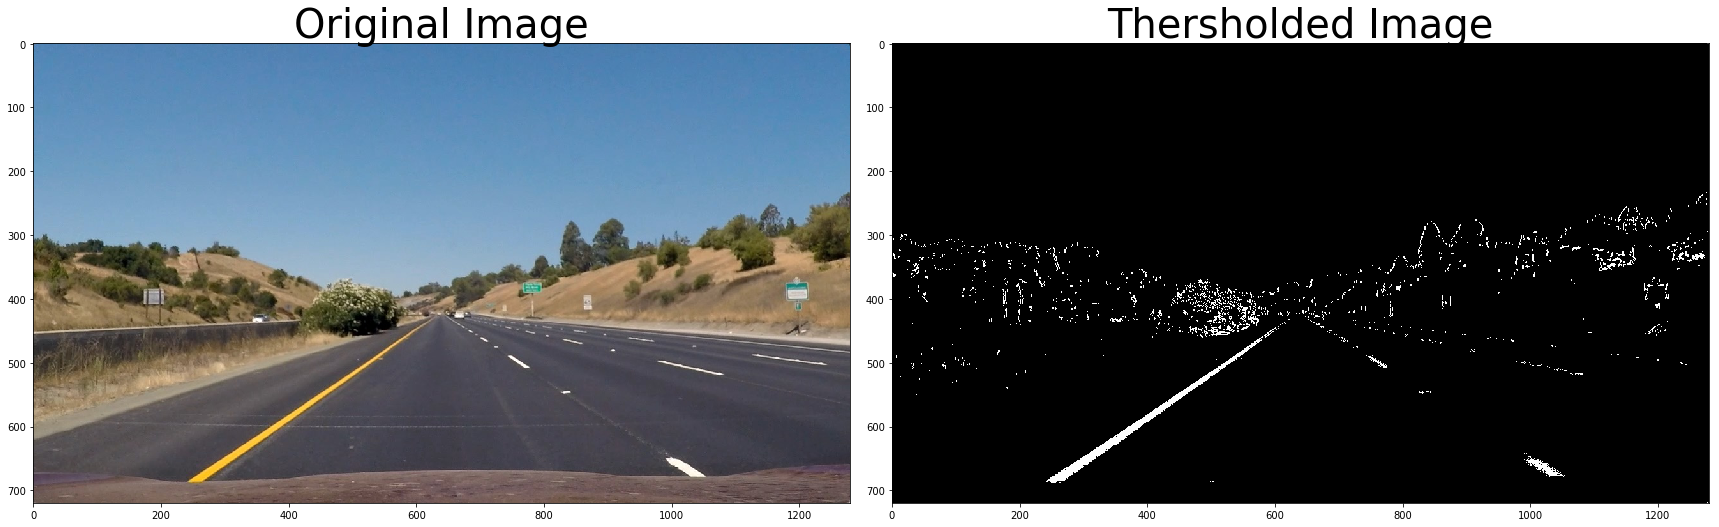

In [4]:
binary_img = combine_threshold(img, (50, 100), (170, 255))
# print(binary_img.shape)
outfile = test_image.replace('test_images', 'output_images').replace('.jpg', '_binary.jpg')
mpimg.imsave(outfile, binary_img, cmap='gray')

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img)
ax1.set_title('Original Image', fontsize=40)

plt.imshow(binary_img, cmap='gray')
ax2.set_title('Thersholded Image', fontsize=40)

## Apply a perspective transform to rectify binary image ("birds-eye view")

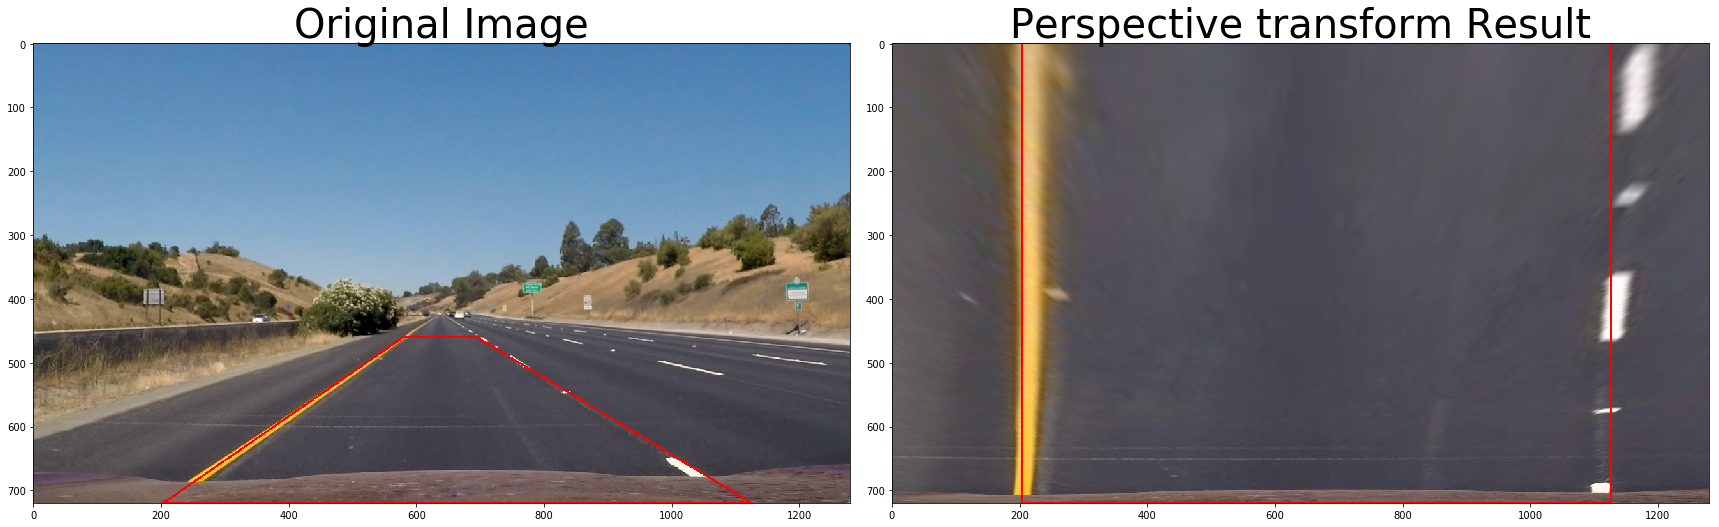

In [5]:
warped, img_copy, _ = warp_perspective(img, visualize=True)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img_copy)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(warped)
ax2.set_title('Perspective transform Result', fontsize=40)


## Apply a perspective transform to the thresholded binary image 

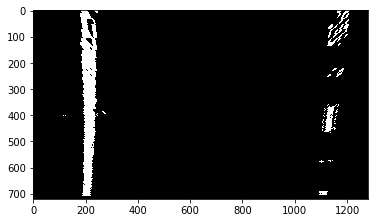

In [6]:
binary_warped, _, Minv = warp_perspective(binary_img, visualize=False)
outfile = test_image.replace('test_images', 'output_images').replace('.jpg', '_binary_warped.jpg')
mpimg.imsave(outfile, binary_warped, cmap='gray')

plt.imshow(binary_warped, cmap='gray')

### Take a histogram along all the columns in the lower half of the binary warped image to idenfy the two peaks

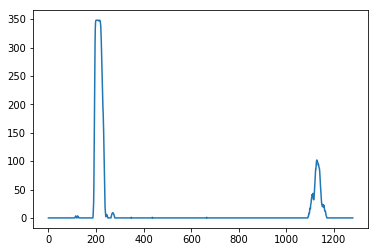

In [7]:
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
plt.plot(histogram)

## Use the sliding windows method to find the lines and fit 2nd order polynomials

In [8]:
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
out_img_copy = np.copy(out_img)
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    
    # Draw the windows on the visualization image   
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 5) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 5) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

(720, 0)

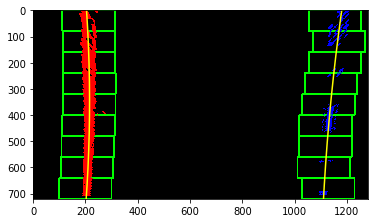

In [9]:
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

(720, 0)

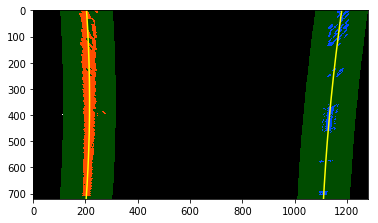

In [10]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

## Warp the detected lane boundaries back onto the original image and visually display lane curvature and vehicle position.

../output_images/straight_lines1_result.jpg


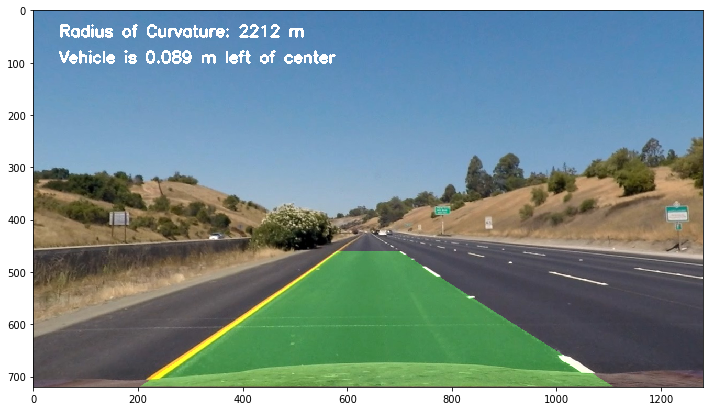

In [11]:
result = draw_lane_lines(binary_warped, undistorted, Minv, Line(), Line())
outfile = test_image.replace('test_images', 'output_images').replace('.jpg', '_result.jpg')
#cv2.imwrite(outfile, binary_img) #saved images are all black when using cv2  
mpimg.imsave(outfile, result)
f, ax = plt.subplots(1, 1, figsize=(12, 9))
ax.imshow(result)
print(outfile)

## Process all test images

In [12]:
test_images = glob.glob('../test_images/*.jpg')
out_folder = '../output_images/'
for infile in test_images:    
    print(infile)
    img = mpimg.imread(infile)   
    last_slash = infile.rfind('\\')
    if last_slash == -1:
        last_slash = infile.rfind('/')
    save_path = out_folder + infile[(last_slash + 1):-4]   
    
    undistorted = undistort(img)
    binary_img = combine_threshold(img, (50, 100), (170, 255))
    binary_warped, _, Minv = warp_perspective(binary_img, visualize=False)
        
    result = draw_lane_lines(binary_warped, undistorted, Minv, Line(), Line()) 
            
    mpimg.imsave(save_path + '_undistorted.jpg', undistorted)
    mpimg.imsave(save_path + '_binary.jpg', binary_img, cmap='gray')
    mpimg.imsave(save_path + '_binary_warped.jpg', binary_warped, cmap='gray')
    mpimg.imsave(save_path + '_result.jpg', result)    

../test_images\straight_lines1.jpg
../test_images\straight_lines2.jpg
../test_images\test1.jpg
../test_images\test2.jpg
../test_images\test3.jpg
../test_images\test4.jpg
../test_images\test5.jpg
../test_images\test6.jpg
